# Load all packages

In [1]:
## general
import numpy as np
import datetime
import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit, fmin
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, te, f

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod, load_data_single_mod_rh
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram
from tools.GBR_fit import get_data_train_gbr

## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
from scipy.interpolate import griddata

## customised tools
import block_cv
import load_data
import sampling

/home/snath/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘RevoUtilsMath’:
 .onLoad failed in loadNamespace() for 'RevoUtilsMath', details:
  call: NULL
  error: Remove Microsoft R and then re-install.
Be sure to select MKL libraries as an install option.

  warnings.warn(x, RRuntimeWarning)
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Get datasets

In [11]:
## Get the Aff, Def datasets for ESMs
data={}
data_lc={}


for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    print('Loading data for: ', model)
    
    print('Loading data for: ', model)
    data=load_data.load_data_tas(data,model)
    data_lc[model]=load_data.load_data_lc(data_lc,model)
    
    idx_l, _, _, lon_pc, lat_pc = load_data.load_meta_data()
    

Loading data for:  Obs
Loading data for:  Obs


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:119: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data[model][var] = [xr.open_mfdataset(config['main_dir']+file_path).roll(lon=72)['%s_local'%var_name].values[:,idx_l]]
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/po

Loading data for:  CESM2
Loading data for:  CESM2


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:123: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data[model][var].append(xr.open_mfdataset(config['main_dir']+file_path.replace('frst-ctl','crop-ctl')).roll(lon=72)['%s_local'%var_name].values[:,idx_l])
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:123: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  data[model][var].append(xr.open_mfdataset(config['main_dir']+file_path.replace('frst-ctl','crop-ctl')).roll(lon=72)['%s_local'%var_name].values[:,idx_l])
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:160: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing beha

Loading data for:  MPI-ESM
Loading data for:  MPI-ESM


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:123: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data[model][var].append(xr.open_mfdataset(config['main_dir']+file_path.replace('frst-ctl','crop-ctl')).roll(lon=72)['%s_local'%var_name].values[:,idx_l])
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
 

Loading data for:  EC-EARTH
Loading data for:  EC-EARTH


/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:144: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  df = xr.open_mfdataset(config['main_dir']+config['lc_map_file_dirs'][model]).roll(lon = 72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/LCLM_module

## Load calibration results

In [ ]:
## get ts_mean CV results
from sklearn.externals import joblib 
import joblib as job

dir_data='/net/so4/landclim/snath/data/LCLM/'

lclm_gam={}
lam_sel={}
n_splines_sel={}
labels_final = {}

lambdas=[0.001,0.01,0.1,1]
n_splines=[5,7,8,9]

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    lam_sel[model]={}
    n_splines_sel[model]={}
    
    labels_final[model] = job.load(dir_data+'ts_'+model+'_idealised_g025/labels_final.pkl')
    
    for var in ['ts_local','ts_mn_local','ts_mx_local']:
    
        if var=='ts_local':

            dir_in_data_mod=dir_data+'ts_'+model+'_idealised_g025/'

        else:

            dir_in_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
       
        scores_lclm_ts=joblib.load(dir_in_data_mod+model+'_FRST_CROP_GAM_CV_results.pkl')
        lclm_gam[model]=job.load(dir_in_data_mod+model+'_FRST_CROP_GAM_final.pkl')

        lam_sel[model][var]={}
        n_splines_sel[model][var]={}

        for i_mon in tqdm(range(12)):
            
            if model=='Obs':
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=GridSearch_sel_obs(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)
            else:
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=GridSearch_sel(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)

                
            


# Get SSP maps

In [5]:
##Extract test and train results
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading_all import load_data_single_mod,load_data_single_mod_lclm,load_data_single_mod_ts
import importlib
importlib.reload(sys.modules['tools.loading_all'])
from tools.loading_all import load_data_single_mod,load_data_single_mod_lclm,load_data_single_mod_ts

gen = 6

time={}

treeFrac_mon={}

run_nrs_treeFrac={}

treeFrac_ref={}


for model in ['CESM2','MPI-ESM1-2-LR']:
    
    print('Getting treeFrac values for, ', model) 
    ##Get training values i.e. monthly/daily model run datas for selected models
    treeFrac_mon[model],treeFrac_ref[model],time[model], run_nrs_treeFrac[model]=load_data_single_mod_lclm(gen,model,usr_time_res="mon",var='treeFrac')

    #Get model
    nr_ts = len(time[model]) #nr time steps (CAMS-CSM1-0 is 230, all others 231)


Getting treeFrac values for,  CESM2
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  data=data.sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:690: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  y_ref=xr.open_mfdataset(dir_lc_ctl).roll(lon=72)['TreeFrac

Getting treeFrac values for,  MPI-ESM1-2-LR
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

/home/snath/polybox/LAMACLIMA/tools/loading_all.py:671: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset(run_name)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/snath/polybox/LAMACLIMA/tools/loading_all.py:674: FutureWarning: roll_coords will be set to Fals

In [8]:
for model in ['CESM2']:


    for scen in treeFrac_mon[model].keys():

        treeFrac_mon[model][scen]=np.stack(([treeFrac_mon[model][scen][run] for run in run_nrs_treeFrac[model][scen]]))
        


# Producing prediction intervals for ssp scenarios

In [ ]:
dir_data='/net/so4/landclim/snath/data/LCLM/'

uncertainty_space={}

for model in ['CESM2','MPI-ESM']:
    
    model_label=model
    if model=='MPI-ESM':
        model_label='MPI-ESM1-2-LR'
    uncertainty_space[model]={}
    
    for var in ['ts_mn_local','ts_mx_local']:

        uncertainty_space[model][var]={}

        for scenario in ['ssp126','ssp370']:

            uncertainty_space[model][var][scenario]=np.full([200,12,idx_l.sum()],np.nan)

            treeFracs_scen_eoc=## open file and extract land array of end of century treemaps for SSPs

            grid_points=np.squeeze(np.argwhere(np.abs(np.nan_to_num(treeFracs_scen_eoc))>=0.01))

            uncertainty_results=Parallel(n_jobs=30)(delayed(get_uncertainty_space)(lclm_gam[model],data[model],
                                                            data_lc[model],i_grid,
                                                            treeFracs_scen_eoc[i_grid], var=var \
                                                            ) for i_grid in tqdm(grid_points))

            for gp,i_grid in enumerate(grid_points):

                uncertainty_space[model][var][scenario][:,:,i_grid]=uncertainty_results[gp]
    

    dir_out_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
        
    joblib.dump(uncertainty_space[model], dir_out_data_mod+model+'_GAM_ssp_uncertainty_space.pkl')
    
            

In [2]:
# Get coeffs from Hooker et al.

coeffs=load_data.load_hooker_coeffs()


/home/snath/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/snath/polybox/LAMACLIMA/LCLM_module/load_data.py:195: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  coeffs[reg][coeff]=xr.open_mfdataset('/net/so4/landclim/snath/data/WP1/Hooker_coeffs/Coeffs_'+reg+'_'+coeff+'_g025.nc').roll(lon=72)[coeff].values[:,idx_l]
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the 

/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


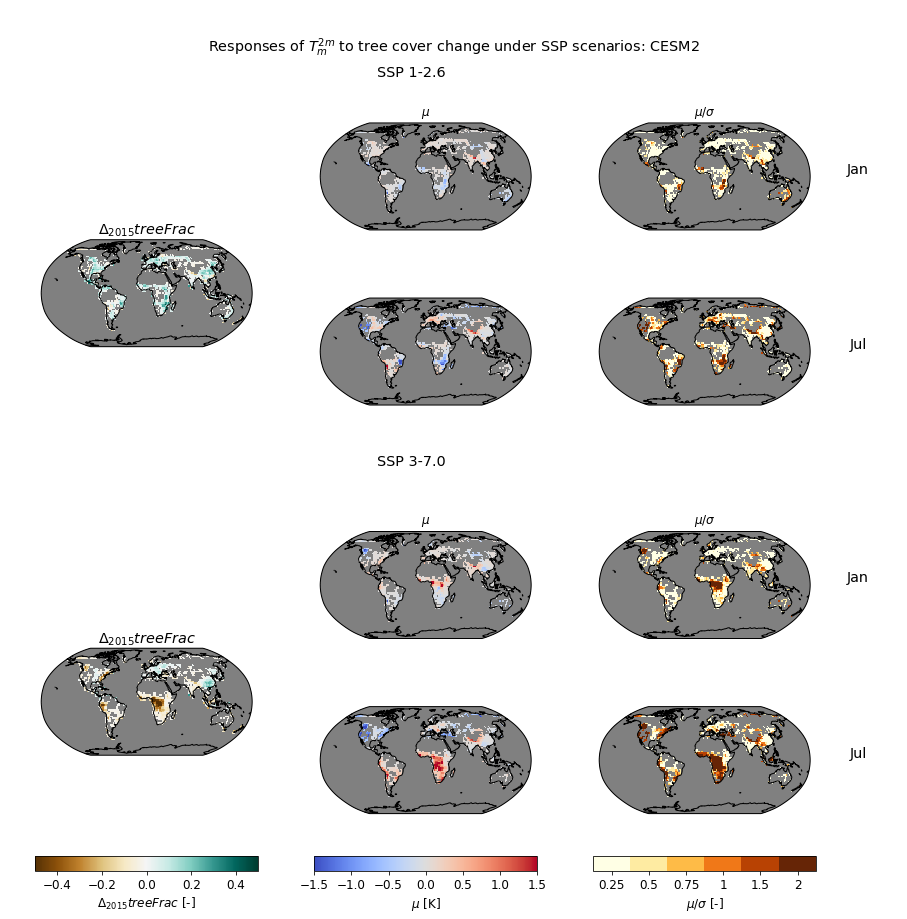

In [12]:
from matplotlib.colors import BoundaryNorm
from sklearn.externals import joblib

dir_data='/net/so4/landclim/snath/data/LCLM/'

model='CESM2'
model_label='CESM2'
fs_title=18
n_row = 4
n_col=3

bounds = [0.15,0.35,0.65,0.85,1.15,1.85,2.15]
norm = BoundaryNorm(boundaries=bounds, ncolors=256)


months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.figure(figsize=(16, 17))

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*4, n_col*10+2, wspace=0, hspace=0.2) # create a grid for the subplots #0.12

axtext=plt.subplot(grid[0,:])
plt.title(r'Responses of $T^{2m}_{m}$ to tree cover change under SSP scenarios: CESM2',y=-0.05)
plt.axis('off')

axtext=plt.subplot(grid[1,:-3])
plt.title(r'SSP 1-2.6',y=0.65)
plt.axis('off')

i=2

dir_in_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
uncertainty_space = joblib.load(dir_in_data_mod+model+'_GAM_ssp_uncertainty_space.pkl')

for scen in ['ssp126','ssp370']:    
    
    treeFracs_scen_eoc=np.nanmean(treeFrac_mon[model][scen].reshape(len(run_nrs_treeFrac[model_label][scen]),-1,12,idx_l.sum())[:,-1,11,:],axis=0)/100
        
        
    ax=plt.subplot(grid[i+2:i+4,:10],projection=ccrs.Robinson(central_longitude=0))

    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)

    y_ma[idx_l]=treeFracs_scen_eoc
    y_ma[np.abs(y_ma)<0.01]=np.nan
    ax.coastlines()
    colormap=plt.get_cmap('BrBG')
    colormap.set_bad('grey')
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('BrBG'), vmin=-0.5, vmax=0.5,transform=ccrs.PlateCarree(),rasterized=True)
    ax.set_facecolor('grey')
    ax.set_title(r'$\Delta_{2015}treeFrac$')

    if scen=='ssp370':
        axcbar=plt.subplot(grid[13:15,1:9])
        cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=15)
        cbar.ax.set_xlabel(r'$\Delta_{2015}treeFrac$ [-]')
        plt.axis('off')
    
    for i_mon in [0,6]:

        t2m_sen=coeffs['GWR']['b1'][i_mon,:]*uncertainty_space['ts_mn_local'][scen][:,i_mon,:]\
                 +coeffs['GWR']['b2'][i_mon,:]*uncertainty_space['ts_mx_local'][scen][:,i_mon,:]       
        
        #t2m_sens[:,np.abs(treeFracs_scen_eoc)<0.05]=np.nan
        
                
        ax=plt.subplot(grid[i:i+2,10:20],projection=ccrs.Robinson(central_longitude=0))
        y_ma = np.zeros(idx_l.shape)
        y_ma = ma.masked_array(y_ma, mask=idx_l==False)

        y_ma[idx_l]=np.nanmean(t2m_sen,axis=0)

        ax.coastlines()
        mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('coolwarm'), vmin=-1.5, vmax=1.5,transform=ccrs.PlateCarree(),rasterized=True)
        colormap=plt.get_cmap('coolwarm')
        colormap.set_bad('grey')
        if i_mon==0:
            ax.set_title(r"$\mu$",y=1.02,fontsize=12)
            
        if scen=='ssp370' and i_mon==0:
            axcbar=plt.subplot(grid[13:15,11:19])
            cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=15)
            cbar.ax.set_xlabel(r'$\mu$ [K]')
            plt.axis('off')
            
        ax=plt.subplot(grid[i:i+2,20:30],projection=ccrs.Robinson(central_longitude=0))
        y_ma = np.zeros(idx_l.shape)
        y_ma = ma.masked_array(y_ma, mask=idx_l==False)

        y_ma[idx_l]=np.abs(np.nanmean(t2m_sen,axis=0))/np.nanstd(t2m_sen,axis=0)
        

        colormap=plt.get_cmap('YlOrBr')
        colormap.set_bad('grey')
        ax.coastlines()
        mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('YlOrBr'), norm=norm,transform=ccrs.PlateCarree(),rasterized=True)
        
        if i_mon==0:
            ax.set_title(r"$\mu/\sigma$",y=1.02,fontsize=12)
            
        axtext=plt.subplot(grid[i+1,-2:-1])
        plt.title(months[i_mon],y=1.05)
        plt.axis('off')
        
        if scen=='ssp370' and i_mon==0:
            axcbar=plt.subplot(grid[13:15,21:29])
            cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=15,ticks=[0.25,0.5,0.75,1,1.5,2])
            cbar.ax.set_xlabel(r'$\mu/\sigma$ [-]')
            cbar.ax.set_xticklabels([0.25,0.5,0.75,1,1.5,2])
            plt.axis('off')

        i+=3
    
    i+=1
       
    
axtext=plt.subplot(grid[8,:-3])
plt.title(r'SSP 3-7.0',y=1.05)
plt.axis('off')



plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/ssp_cesm_dist.pdf')

